# Предсказание рейтинга качества шоколада по его характеристикам
## Соревнование в рамках курса "Практический ML"

## Никнейм на kaggle: dannierel

результат: 0.20420

Просьба авторам курса: если есть такая возможность, можете, пожалуйста подтвердить или опровергнуть выводы, которые я оставлял в текстовых полях? Имею в виду правильность рассуждений. Заранее большое вам спасибо!

Мои слёзы такие же горькие, как шоколад бабаевский

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# EDA

In [3]:
df_train = pd.read_csv('/kaggle/input/practical-ml-chocolate/chocolate_train.csv')
df_test = pd.read_csv('/kaggle/input/practical-ml-chocolate/chocolate_test_new.csv')

**Company** - компания производитель

**Specific Bean Origin** - географический регион происхождения

**REF** - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)

**Review** - дата публикации отзыва

**Cocoa Percent** - процентное содержание какао

**Company Location** - страна производитель

**Rating** - экспертный рейтинг (target)

**Bean Type** - используемый сорт какао-бобов, если таковой имеется

**Broad Bean Origin** - географический регион происхождения какао-бобов

In [4]:
df_train.sample(5)

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
1231,Askinosie,Xoconusco,141,2007,75%,U.S.A.,2.50,Trinitario,Mexico
1000,Pralus,"Monte Alegre, Diego Badero",280,2008,75%,France,3.50,,Brazil
1013,Pacari,"Ecuador, raw",817,2012,85%,Ecuador,2.75,,Ecuador
893,Daintree,"Daintree Estates, N. Queensland",785,2011,70%,Australia,3.25,,Australia
624,Amano,Chuao,544,2010,70%,U.S.A.,3.00,Trinitario,Venezuela


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   object 
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 88.4+ KB


In [6]:
# преобразуем процент какао в вещественный тип
df_train['Cocoa Percent'] = df_train['Cocoa Percent'].map(lambda x: float(x.strip('%')))
df_test['Cocoa Percent'] = df_test['Cocoa Percent'].map(lambda x: float(x.strip('%')))
df_train['Cocoa Percent']

0       72.0
1       72.0
2       70.0
3       72.0
4       75.0
        ... 
1250    80.0
1251    70.0
1252    68.0
1253    72.0
1254    70.0
Name: Cocoa Percent, Length: 1255, dtype: float64

In [7]:
# выведем информацию о датасете, чтобы посмотреть типы колонок, кол-во пропусков
for df in [df_train, df_test]:
    print(df.info())
    print('====================================')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   float64
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 88.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               540 non-null    object 
 1   Spe

В датасете 5 категориальных переменных, 4 численные, одна из которых - целевая. 

В тренировочном датасете 2 NaN пропуска, в тестовом 0.

In [8]:
# выведем сведения о датасетах
for df in [df_train, df_test]:
    print(df.describe())
    print('------------------------------------')
    print(df.describe(include='object'))
    print('====================================')

               REF       Review  Cocoa Percent       Rating
count  1255.000000  1255.000000    1255.000000  1255.000000
mean   1045.152191  2012.382470      71.790438     3.176494
std     551.284249     2.922499       6.397448     0.478948
min       5.000000  2006.000000      46.000000     1.000000
25%     593.000000  2010.000000      70.000000     2.750000
50%    1077.000000  2013.000000      70.000000     3.250000
75%    1514.000000  2015.000000      75.000000     3.500000
max    1952.000000  2017.000000     100.000000     5.000000
------------------------------------
       Company Specific Bean Origin Company Location Bean Type  \
count     1255                 1255             1255      1254   
unique     376                  762               58        38   
top       Soma           Madagascar           U.S.A.             
freq        35                   39              521       628   

       Broad Bean Origin  
count               1254  
unique                84  
top        

В целом можно сказать, что распределение симметричное (Такой вывод сделан, по тому, что поля mean и 50% квартиль не сильно различаются).

У колонки Review очень маленькое средне квадратичное отклонение, такую колонку следует удалить с точки зрения того, что у признака низкая вариативность. (С другой стороны StandardScaler всё равно приводит значения признака к отклонению 1). И как будто два этих признака имеют один и тот же смысл

Ещё можно заметить, что в колонке Bean Type пропуски закодированы пустым значением.
Проверим это:

In [9]:
# посмотрим как закодированы пропуски
df_train['Bean Type'][203]

'\xa0'

In [10]:
# заменим пустые значения на NaN
df_train = df_train.replace('\xa0', np.nan)
df_test = df_test.replace('\xa0', np.nan)

In [11]:
# выведем информацию о датасете, чтобы посмотреть типы колонок, кол-во пропусков
for df in [df_train, df_test]:
    print(df.info())
    print('====================================')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   float64
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             626 non-null    object 
 8   Broad Bean Origin     1199 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 88.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               540 non-null    object 
 1   Spe

Построим графики, матрицу корреляций и матрицу для V-меры Краммера

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

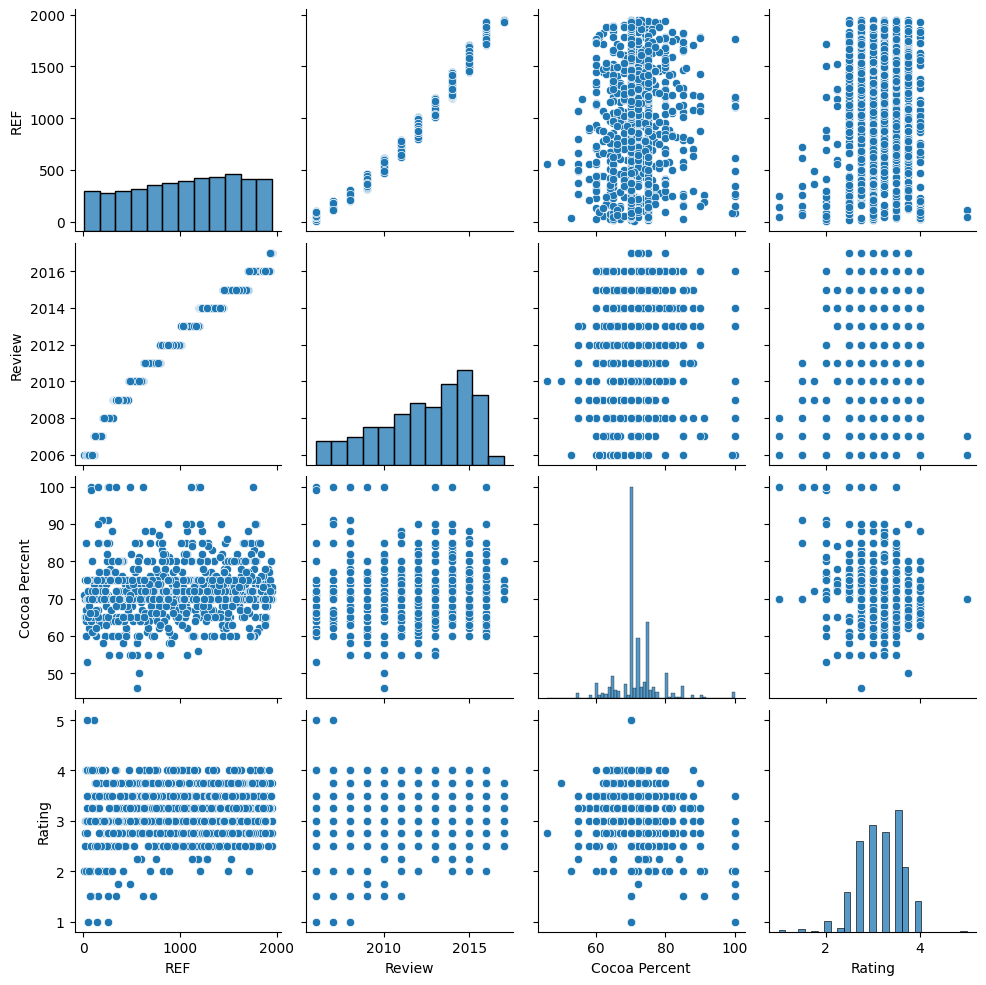

In [12]:
import seaborn as sns
sns.pairplot(df_train, kind='scatter')

Какие выводы можно сделать из данных графиков:

Колонки REF и Review действительно очень походи, тогда Review стоит удалить

Попробовать привести колонку REF к нормальному распределению (С другой стороны ансамбли деревьев такие как случайный лес и бустинги не требуют нормального распределения в признаках)

Целевая переменная имеет распределение похожее на нормальное

Выбросов нигде нет

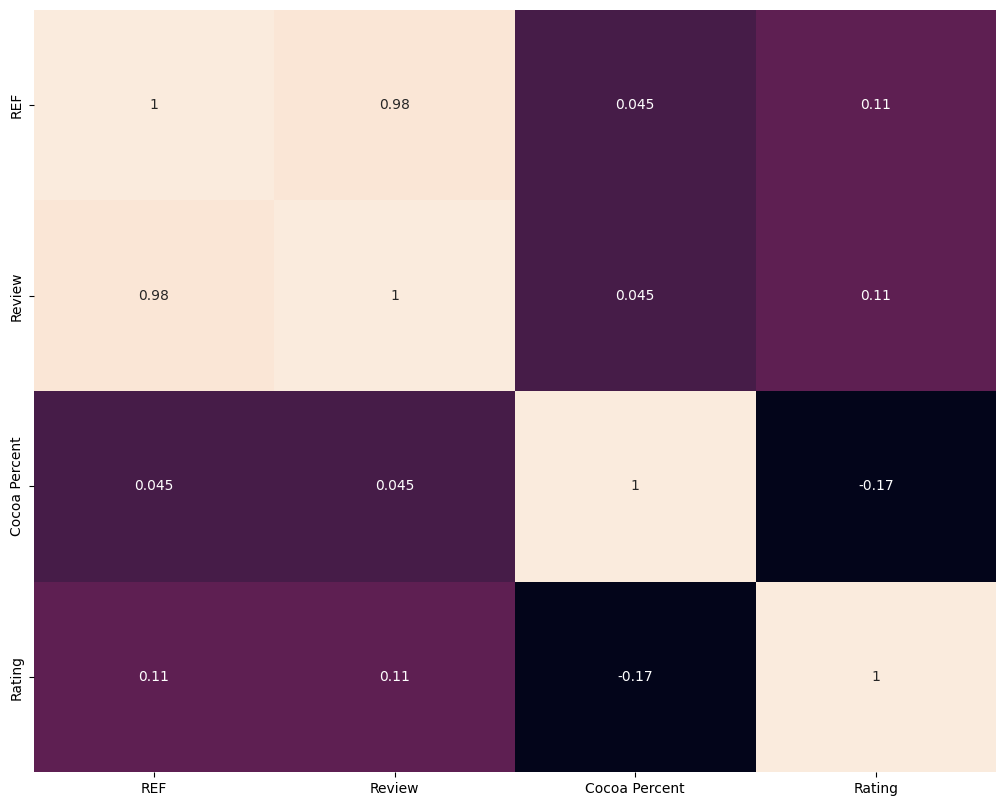

In [21]:
# матрица корреляций
num_cols = df_train.columns[df_train.dtypes != 'object']
plt.figure(figsize=(10,8))
sns.heatmap(df_train[num_cols].corr(),annot=True,cbar=False)
plt.tight_layout(pad=0.5)
plt.show()

Из матрицы корреляций видно большую коллениарность у столбцов REF и Review

In [22]:
!pip install association-metrics

  Preparing metadata (setup.py) ... done
  Created wheel for association-metrics: filename=association_metrics-0.0.1-py3-none-any.whl size=3930 sha256=4734673e3fa78af31a808d3377fab5fbc664d92d4ab01f3ecc58bb1e83c2133a
  Stored in directory: /root/.cache/pip/wheels/01/47/5f/4360ef6988df6f1b0c1857cab43334269110160bd97b716936
Successfully built association-metrics


In [23]:
import association_metrics as am
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

XC = df_train.apply(
        lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(XC)

cramersv.fit()

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin
Company,1.000000,0.771074,0.999651,0.699234,0.606780
Specific Bean Origin,0.771074,1.000000,0.808500,0.945435,0.986510
Company Location,0.999651,0.808500,1.000000,0.335082,0.384231
Bean Type,0.699234,0.945435,0.335082,1.000000,0.460058
Broad Bean Origin,0.606780,0.986510,0.384231,0.460058,1.000000


Большая коллениарность у пар Broad Bean Origin и Specific Bean Origin, Company и Company Location, Bean Type и Specific Bean Origin

Для удаления я бы выбрал: 

Specific Bean Origin т.к. данный признак коллениарен с двумя другими, также в нём большая вариативность (в прошлый раз оставил REF как раз из-за большей вариативности, но в этом случае рассматривается категориальная переменная, у которой оч большое количество уникальных значений = рискуем недообучиться)

Company Location т.к. этот признак менее информативен, чем Company (ну я так думаю)

Т.к. я прохожу это соревнование после просмотра всего курса, попробую произвести отбор признаков с помощью модели, а именно CatBoost


In [13]:
!pip install catboost -q

In [14]:
from catboost import CatBoostRegressor, cv, metrics, Pool
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score

In [15]:
# создадим копии датасетов для заполнения пропусков для данного эксперимента
df_tr_copy = df_train.copy()
df_ts_copy = df_test.copy()

In [16]:
df_tr_copy, df_ts_copy = df_tr_copy.fillna(-999), df_ts_copy.fillna(-999)

In [17]:
# выведем информацию о датасете, чтобы посмотреть типы колонок, кол-во пропусков
for df in [df_tr_copy, df_ts_copy]:
    print(df.info())
    print('====================================')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   float64
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1255 non-null   object 
 8   Broad Bean Origin     1255 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 88.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               540 non-null    object 
 1   Spe

In [19]:
y, X = df_tr_copy['Rating'], df_tr_copy.drop(['Rating'], axis=1)
X.sample(5)

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
444,Pierre Marcolini,"Bahia Brazil, Fazenda Sao Pedro",414,2009,72.0,Belgium,Forastero,Brazil
251,Cacao Barry,Venezuela,141,2007,72.0,France,-999,Venezuela
174,Willie's Cacao,San Martin,457,2009,70.0,U.K.,-999,Peru
57,Duffy's,"Bocas del Toro, Tierra Oscura",697,2011,72.0,U.K.,-999,Panama
798,Black Mountain,Carenero Superior,256,2008,70.0,U.S.A.,Trinitario,Venezuela


In [20]:
cat_cols = np.array(X.columns[X.dtypes == 'object'])
cat_cols

array(['Company', 'Specific Bean Origin', 'Company Location', 'Bean Type',
       'Broad Bean Origin'], dtype=object)

In [31]:
cb = CatBoostRegressor(random_seed=42, verbose=0, eval_metric='R2')
pool = Pool(data=X, label=y, cat_features=cat_cols)

In [32]:
cv_params = cb.get_params()
cv_data = cv(pool, params=cv_params, fold_count=3, shuffle=True, plot=False)

Training on fold [0/3]

bestTest = 0.1646962584
bestIteration = 583

Training on fold [1/3]

bestTest = 0.1969602318
bestIteration = 219

Training on fold [2/3]

bestTest = 0.1962611036
bestIteration = 924



In [33]:
print("Среднее R² на кросс-валидации:", cv_data['test-R2-mean'].max())

Среднее R² на кросс-валидации: 0.18062146269751714


In [34]:
cb.fit(X, y, cat_features=cat_cols)
feature_importances = cb.get_feature_importance()
feature_names = X.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

Company: 18.651606571965296
Broad Bean Origin: 15.36251888276266
Company Location: 14.787939271975716
REF: 14.552692511089873
Cocoa Percent: 13.871862526558141
Bean Type: 12.365512718003119
Specific Bean Origin: 5.900122265630082
Review: 4.507745252015015


В общем Review и Specific Bean Origin точно удаляем, но сначала посмотрим на Lasso-регрессию, которая зануляет веса, таким образом можно отобрать признаки

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso

In [36]:
p = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', Lasso(alpha=0.001))
])
cross_val_score(p, X, y, scoring='r2').mean()

0.1301335174254955

In [37]:
p.fit(X, y)
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': p.named_steps['model_'].coef_
})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
print(coef_df.to_string(index=False))

             Feature  Coefficient
             Company     0.148892
              Review     0.048223
           Bean Type     0.034521
Specific Bean Origin     0.030353
   Broad Bean Origin     0.016282
                 REF    -0.000000
    Company Location    -0.008331
       Cocoa Percent    -0.084479


L1-регуляризация занулила признаки у REF, но мы уже решили удалить Review. Итого удалим признаки Review, Specific Bean Origin, Company Location

In [22]:
# создадим копии датасетов для заполнения пропусков для данного эксперимента
df_tr_copy = df_train.copy()
df_ts_copy = df_test.copy()

In [23]:
df_tr_copy, df_ts_copy = df_tr_copy.fillna(-999), df_ts_copy.fillna(-999)

Путём экспериментов лучшее качество показал себя датасет без этих признаков

In [24]:
df_tr_copy, df_ts_copy = df_tr_copy.drop(['Review', 'Specific Bean Origin'], axis=1), \
                            df_ts_copy.drop(['Review', 'Specific Bean Origin'], axis=1)

In [25]:
# выведем информацию о датасете, чтобы посмотреть типы колонок, кол-во пропусков
for df in [df_tr_copy, df_ts_copy]:
    print(df.info())
    print('====================================')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company            1255 non-null   object 
 1   REF                1255 non-null   int64  
 2   Cocoa Percent      1255 non-null   float64
 3   Company Location   1255 non-null   object 
 4   Rating             1255 non-null   float64
 5   Bean Type          1255 non-null   object 
 6   Broad Bean Origin  1255 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 68.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company            540 non-null    object 
 1   REF                540 non-null    int64  
 2   Cocoa Percent      540 non-null    float64
 3   Company Location   540 non-null    object 
 4

# Обучение Моделей

Посмотрим насколько изменилось качество у CatBoost

In [26]:
y, X = df_tr_copy['Rating'], df_tr_copy.drop(['Rating'], axis=1)
X.sample(5)

,Company,REF,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
796,Cao,1804,75.0,U.S.A.,Criollo,Venezuela
678,Ethel's Artisan (Mars),666,70.0,U.S.A.,Criollo (Porcelana),Venezuela
936,Beschle (Felchlin),636,72.0,Switzerland,-999,Ecuador
558,Akesson's (Pralus),508,75.0,Switzerland,Forastero,Brazil
1249,twenty-four blackbirds,1026,75.0,U.S.A.,-999,Bolivia


In [27]:
cat_cols = np.array(X.columns[X.dtypes == 'object'])
cat_cols

array(['Company', 'Company Location', 'Bean Type', 'Broad Bean Origin'],
      dtype=object)

In [28]:
cb = CatBoostRegressor(random_seed=42, verbose=0, eval_metric='R2')
pool = Pool(data=X, label=y, cat_features=cat_cols)
cv_params = cb.get_params()
cv_data = cv(pool, params=cv_params, fold_count=3, shuffle=True, plot=False)
print("Среднее R² на кросс-валидации:", cv_data['test-R2-mean'].max())

Training on fold [0/3]

bestTest = 0.1638502378
bestIteration = 444

Training on fold [1/3]

bestTest = 0.193601868
bestIteration = 494

Training on fold [2/3]

bestTest = 0.1948484754
bestIteration = 443

Среднее R² на кросс-валидации: 0.1836556860396736


Теперь обучим на трейне и посмотрим сколько получим на тесте

In [29]:
cb = CatBoostRegressor(random_seed=42, verbose=0, eval_metric='R2')
cb.fit(X, y, cat_features=cat_cols)
y_pred = cb.predict(df_ts_copy)

In [168]:
res = pd.DataFrame({
    'id': df_ts_copy.index,
    'Rating': y_pred
})

res.to_csv("test_prediction.csv", index=False)

Такая модель дала 0.1839 на тестовых данных

попробуем подобрать параметры с помощью библиотеки optuna

In [30]:
!pip install optuna -q

In [31]:
import optuna

## CatBoost

In [ ]:
def objective(trial: optuna.Trial) -> float:

    param = {
        "iterations": trial.suggest_int("iterations", 4000, 10000, step=2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.31, step=0.05),
        "depth": trial.suggest_int("depth", 4, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 1, step=0.05),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 5.5, step=0.5),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli"]
        ),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1, 30),
        'use_best_model': True,
        'eval_metric': 'R2',
        'random_state': 42,
        'logging_level': 'Silent'
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    cb = CatBoostRegressor(**param)

    pool = Pool(data=X, label=y, cat_features=cat_cols)
    cv_params = cb.get_params()
    cv_data = cv(pool, params=cv_params, fold_count=3, shuffle=True, plot=False)

    return cv_data['test-R2-mean'].max()

study = optuna.create_study(direction="maximize", study_name=f'catboost-seed{42}')
study.optimize(objective, n_trials=50, timeout=6000)
print(study.best_trial)

{'iterations': 6000,
 'learning_rate': 0.01,
 'depth': 4,
 'colsample_bylevel': 0.20095492206523796,
 'l2_leaf_reg': 1.0,
 'bootstrap_type': 'Bernoulli',
 'min_data_in_leaf': 13,
 'subsample': 0.686539190455382}
 
 R2: 0.18619772092672046

На втором прогоне выдало лучший результат

FrozenTrial(number=45, state=TrialState.COMPLETE, values=[0.19423564751650332], datetime_start=datetime.datetime(2024, 10, 11, 9, 30, 29, 337425), datetime_complete=datetime.datetime(2024, 10, 11, 9, 30, 52, 100183), params={'iterations': 6000, 'learning_rate': 0.16000000000000003, 'depth': 4, 'colsample_bylevel': 0.5, 'l2_leaf_reg': 2.0, 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 1, 'bagging_temperature': 1.8988916879985898},

На тертьем:

values=[0.18756282933009596], datetime_start=datetime.datetime(2024, 10, 11, 15, 29, 4, 719725), datetime_complete=datetime.datetime(2024, 10, 11, 15, 29, 22, 402809), params={'iterations': 6000, 'learning_rate': 0.060000000000000005, 'depth': 4, 'colsample_bylevel': 0.30000000000000004, 'l2_leaf_reg': 2.0, 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 10, 'subsample': 0.6835402571560444}

Посмотрим, какой результат покажет на тестовых данных

In [48]:
# первый поиск с optuna
#  params = {'iterations': 6000,
#  'learning_rate': 0.01,
#  'depth': 4,
#  'colsample_bylevel': 0.20095492206523796,
#  'l2_leaf_reg': 1.0,
#  'bootstrap_type': 'Bernoulli',
#  'min_data_in_leaf': 13,
#  'subsample': 0.686539190455382}

# второй поиск с optuna
# params = {
#     'iterations': 6000, 
#     'learning_rate': 0.16000000000000003,
#     'depth': 4,
#     'colsample_bylevel': 0.5,
#     'l2_leaf_reg': 2.0,
#     'bootstrap_type': 'Bayesian',
#     'min_data_in_leaf': 1,
#     'bagging_temperature': 1.8988916879985898
# }

# третий поиск с optuna
params = {
    'iterations': 6000,
    'learning_rate': 0.060000000000000005,
    'depth': 4,
    'colsample_bylevel': 0.30000000000000004,
    'l2_leaf_reg': 2.0,
    'bootstrap_type': 'Bernoulli',
    'min_data_in_leaf': 10,
    'subsample': 0.6835402571560444
}

In [51]:
cb = CatBoostRegressor(
    **params,
    eval_metric = 'R2',
    random_state = 42,
    logging_level = 'Silent',
)
cb.fit(X, y, cat_features=cat_cols)
y_pred = cb.predict(df_ts_copy)

res = pd.DataFrame({
    'id': df_ts_copy.index,
    'Rating': y_pred
})

res.to_csv("test_prediction_cb_optuna_v3.csv", index=False)

результат R2 с гиперпараметрами v1 на тесте: 0.18718

результат R2 с гиперпараметрами v2 на тесте: 0.01995

результат R2 с гиперпараметрами v3 на тесте: 0.10996

Почему результат во втором случае лучше (0.194 vs 0.186) при поиске гиперпараметров, но на тесте получился результат в 10 раз хуже????
Не думаю, что при метрике 0.19 в кросс-валидации можно говорить о переобучении...

## XGBoost

In [53]:
!pip install xgboost -q

In [76]:
import xgboost as xgb
from sklearn.metrics import r2_score

In [195]:
df_tr_copy = df_train.copy()
df_ts_copy = df_test.copy()
df_tr_copy, df_ts_copy = df_tr_copy.fillna(-999), df_ts_copy.fillna(-999)
df_tr_copy, df_ts_copy = df_tr_copy.drop(['Review', 'Specific Bean Origin'], axis=1), \
                            df_ts_copy.drop(['Review', 'Specific Bean Origin'], axis=1)

In [219]:
y, X = df_tr_copy['Rating'], df_tr_copy.drop(['Rating'], axis=1)
cat_cols = np.array(X.columns[X.dtypes == 'object'])
X.sample(5)

,Company,REF,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
717,Urzi,1327,65.0,Italy,Trinitario,Venezuela
610,Palette de Bine,1570,70.0,Canada,Trinitario,Trinidad
555,Zak's,1574,70.0,U.S.A.,-999,Papua New Guinea
0,Willie's Cacao,457,72.0,U.K.,Trinitario,Venezuela
263,Dole (Guittard),311,70.0,U.S.A.,-999,Hawaii


In [220]:
for col in cat_cols:
    X[col] = X[col].astype('category')
    
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Company            1255 non-null   category
 1   REF                1255 non-null   int64   
 2   Cocoa Percent      1255 non-null   float64 
 3   Company Location   1255 non-null   category
 4   Bean Type          1255 non-null   category
 5   Broad Bean Origin  1255 non-null   category
dtypes: category(4), float64(1), int64(1)
memory usage: 43.5 KB


In [221]:
params = {
    'seed': 42,
    'enable_categorical': True
}

xgb_reg = xgb.XGBRegressor(**params)

cross_val_score(xgb_reg, X, y, scoring='r2', cv=3).mean()

0.042829636838951836

In [ ]:
def objective(trial: optuna.Trial) -> float:

    param = {
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        'n_estimators': trial.suggest_int("n_estimators", 1000, 10000),
        'reg_alpha': trial.suggest_float("reg_alpha", 1e-8, 100.0),
        'reg_lambda': trial.suggest_float("reg_lambda", 1e-8, 100.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0, step=0.1),
        'seed': 42,
        'enable_categorical': True
    }
        
    xgb_reg = xgb.XGBRegressor(**param)
    cv_data = cross_val_score(xgb_reg, X, y, scoring='r2', cv=3).mean()

    return cv_data

study = optuna.create_study(direction="maximize", study_name=f'xgb-seed{42}')
study.optimize(objective, n_trials=50, timeout=6000)
print(study.best_trial)

In [202]:
study.best_params

{'learning_rate': 0.031697645105892604,
 'max_depth': 4,
 'colsample_bytree': 0.2966514447496226,
 'min_child_weight': 1,
 'n_estimators': 1037,
 'reg_alpha': 0.3618193754651644,
 'reg_lambda': 55.13151257489271,
 'subsample': 0.5}

{'learning_rate': 0.04020865561484986,
 'max_depth': 6,
 'subsample': 0.8031258078469657,
 'colsample_bytree': 0.6572474586290444,
 'min_child_weight': 3}
 
 r2: 0.21408953067049474

In [142]:
# params = {
#     'learning_rate': 0.04020865561484986,
#     'max_depth': 6,
#     'subsample': 0.8031258078469657,
#     'colsample_bytree': 0.6572474586290444,
#     'min_child_weight': 3,
#     'seed': 42,
#     'enable_categorical': True
# }

# params_v2 = {
#     'learning_rate': 0.04706660767001285,
#     'max_depth': 8,
#     'subsample': 0.5995048429823823,
#     'colsample_bytree': 0.41127957064923054,
#     'min_child_weight': 2,
#     'seed': 42,
#     'enable_categorical': True
# }

params_v3 = {
    'learning_rate': 0.04153782182927691,
    'max_depth': 4,
    'colsample_bytree': 0.5561583171156319,
    'min_child_weight': 9,
    'n_estimators': 3880,
    'reg_alpha': 6.654961745435298,
    'reg_lambda': 5.28088106358234,
    'subsample': 0.7,
    'seed': 42,
    'enable_categorical': True
}

In [222]:
X_ts = df_ts_copy.copy()

In [223]:
# для работы с категориальными значениями
for col in cat_cols:
    X_ts[col] = X_ts[col].astype('category')
    
X_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Company            540 non-null    category
 1   REF                540 non-null    int64   
 2   Cocoa Percent      540 non-null    float64 
 3   Company Location   540 non-null    category
 4   Bean Type          540 non-null    category
 5   Broad Bean Origin  540 non-null    category
dtypes: category(4), float64(1), int64(1)
memory usage: 25.8 KB


In [143]:
xgb_reg = xgb.XGBRegressor(**params_v3)
xgb_reg.fit(X, y)
y_pred = xgb_reg.predict(X_ts)

res = pd.DataFrame({
    'id': df_ts_copy.index,
    'Rating': y_pred
})

res.to_csv("test_prediction_xgb_optuna_v3.csv", index=False)

Попробуем сложить результаты

In [112]:
res.head()

,id,Rating
0,0,2.913789
1,1,3.076824
2,2,2.977238
3,3,3.440506
4,4,2.864545


In [146]:
res_cb_w_xgb = pd.DataFrame({
    'id': df_ts_copy.index,
    'Rating': y_pred
})

rating_cb = pd.read_csv('/kaggle/working/test_prediction_cb_optuna_v1.csv')['Rating']

res_cb_w_xgb['Rating'] = 0.1 * res_cb_w_xgb['Rating'] + 0.9 * rating_cb

res_cb_w_xgb.to_csv("test_prediction_cb_w_xgb_v999.csv", index=False)

0.1 xgb v 3 + 0.9 cb v 1 = 0.18894

## LightGBM

In [170]:
!pip install lightgbm -q

In [234]:
from lightgbm import LGBMRegressor

In [225]:
y, X = df_tr_copy['Rating'], df_tr_copy.drop(['Rating'], axis=1)
cat_cols = np.array(X.columns[X.dtypes == 'object'])
X.sample(5)

,Company,REF,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
1058,Soma,676,70.0,Canada,-999,"Ven, Bolivia, D.R."
191,Pump Street Bakery,1223,72.0,U.K.,Trinitario,Madagascar
403,Just Good Chocolate,1375,70.0,U.S.A.,Trinitario,Belize
246,Choocsol,1832,75.0,Canada,-999,Mexico
805,Svenska Kakaobolaget,1618,70.0,Sweden,"Criollo, Trinitario",Sri Lanka


In [232]:
p = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', LGBMRegressor(seed=42, verbose=0))
])

cross_val_score(p, X, y, cv=3, scoring='r2').mean()

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

0.08901399864198234

In [ ]:
def objective(trial):
    params = {
        "objective": "regression",
        "n_estimators": 3500,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
    
    p = Pipeline([
        ('encoder_',TargetEncoder(cols=cat_cols)),
        ('scaler_', StandardScaler()),
        ('model_', LGBMRegressor(seed=42, **params))
    ])

    
    cv_result = cross_val_score(p, X, y, cv=3, scoring='r2').mean()
    return cv_result

study = optuna.create_study(direction="maximize", study_name=f'lgbm-seed{42}')
study.optimize(objective, n_trials=50, timeout=6000)
print(study.best_trial)

In [245]:
study.best_params

{'learning_rate': 0.0010251737439944044,
 'num_leaves': 619,
 'subsample': 0.1227695856689647,
 'colsample_bytree': 0.5560958741651525,
 'min_data_in_leaf': 1}

In [249]:
# r2 = 0.1868...
params_v1 = {
    'learning_rate': 0.0014273638414273693,
    'num_leaves': 566,
    'subsample': 0.9177967585407902,
    'colsample_bytree': 0.42946156059076773,
    'min_data_in_leaf': 7,
    "objective": "regression",
    "n_estimators": 1000,
    "verbosity": -1,
    "bagging_freq": 1
}

# r2 = 0.1761...
params_v2 = {
    'learning_rate': 0.0034949357044317757,
    'num_leaves': 547,
    'subsample': 0.7945679364153312,
    'colsample_bytree': 0.5550112241203383,
    'min_data_in_leaf': 6,
    "objective": "regression",
    "n_estimators": 1000,
    "verbosity": -1,
    "bagging_freq": 1
}

# r2 = 0.1738...
params_v3 = {
    "objective": "regression",
    "n_estimators": 3500,
    "verbosity": -1,
    "bagging_freq": 1,
    'learning_rate': 0.0010251737439944044,
    'num_leaves': 619,
    'subsample': 0.1227695856689647,
    'colsample_bytree': 0.5560958741651525,
    'min_data_in_leaf': 1
}

In [250]:
p = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', LGBMRegressor(seed=42, **params_v3))
])

p.fit(X, y)
y_pred = p.predict(df_ts_copy)

res = pd.DataFrame({
    'id': df_ts_copy.index,
    'Rating': y_pred
})

res.to_csv("test_prediction_lgbm_optuna_v3.csv", index=False)

v1 показывает себя лучше всего, попробуем смешать cb v1 и lgbm v1 

In [260]:
res_cb_w_lgbm = pd.DataFrame({
    'id': df_ts_copy.index,
    'Rating': y_pred
})

rating_cb = pd.read_csv('/kaggle/working/test_prediction_cb_optuna_v1.csv')['Rating']
rating_lgbm = pd.read_csv('/kaggle/working/test_prediction_lgbm_optuna_v1.csv')['Rating']

res_cb_w_lgbm['Rating'] = 0.3 * rating_lgbm + 0.7 * rating_cb

res_cb_w_lgbm.to_csv("test_prediction_cb_w_lgbm_0.3-0.7.csv", index=False)

УРА ТАКАЯ КОМБИНАЦИЯ ДАЛА 0.20351 НА ПРИВАТЕ

In [262]:
res_cb_w_lgbm = pd.DataFrame({
    'id': df_ts_copy.index,
    'Rating': y_pred
})

rating_cb = pd.read_csv('/kaggle/working/test_prediction_cb_optuna_v1.csv')['Rating']
rating_lgbm = pd.read_csv('/kaggle/working/test_prediction_lgbm_optuna_v1.csv')['Rating']

res_cb_w_lgbm['Rating'] = 0.2 * rating_lgbm + 0.8 * rating_cb

res_cb_w_lgbm.to_csv("test_prediction_cb_w_lgbm_0.2-0.8.csv", index=False)

In [264]:
res_cb_w_lgbm = pd.DataFrame({
    'id': df_ts_copy.index,
    'Rating': y_pred
})

rating_cb = pd.read_csv('/kaggle/working/test_prediction_cb_optuna_v1.csv')['Rating']
rating_lgbm = pd.read_csv('/kaggle/working/test_prediction_lgbm_optuna_v1.csv')['Rating']

res_cb_w_lgbm['Rating'] = 0.4 * rating_lgbm + 0.6 * rating_cb

res_cb_w_lgbm.to_csv("test_prediction_cb_w_lgbm_0.4-0.6.csv", index=False)

Вот эта комбинация дала 0.20420 на привате

После выполнения данного задания у меня есть немного вопросов, и я был бы очень рад, если вы на них ответите:
1) Optuna стартует из случайного места, соответственно с каждым запуском подбора гиперпараметра, они будут подбираться по-разному. Имеет ли это какое-либо значение в общем смысле? Я имею в виду, что имеет ли значение разброс метрики пусть даже +- 0.05?

2) Один раз при подборе гиперпараметров, получились гиперпараметры с качеством 0.19..., но на тесте она дала всего лишь 0.02, в то время как попытка с качеством 0.18.. дала на тесте 0.18... Можно ли из этого сделать какой-либо вывод? Говорит ли это о переобучении?

3) Можно ли говорить о переобучении в ситуации когда метрика на трейне и тесте различается в несколько раз, если метрика довольно низкая?

4) Последним шагам в моём EDA было удаление признаков. После удаления признаков я решил поэкспериментировать и удалял итеративно признаки в разных сочетаниях, чтобы посмотреть как меняется качество у CatBoost, и получилось такая ситуация, что при удалении одного из мультиколлениарных признаков  качество упало (хотя чисто в теории должно быть наоборот). Можно ли сказать, что это произошло из-за маленького кол-ва признаков и объектов в датасете? Есть ли вообще смысл так сильно анализировать датасет или можно просто использовать алгоритмы рекурсивного отбора признаков на маленьких датасетах? К тому же у нас могла быть ситуация, в которой модель с подобранными Optuna гиперпараметрами обученная на датасете со всеми признаками показала бы лучшее качество, как быть в такой ситуации? Ведь проверять все сочетания датасетов с подбором признаков очень долго и чисто логически не очень правильно...

Буду очень рад получить ответы на мои вопросы, я получил удовольствие, когда проходил этот курс и особенно когда решал эту домашку!!!!